## Accessing StreamCat data in Python with [HyRiver](https://docs.hyriver.io/)

Suite of Python packages with a unified API for retrieving climatic, hydrologic
and other geospatial/temporal data from various web services


In [2]:
from IPython.display import IFrame
IFrame(src='https://hyriver.readthedocs.io/en/latest', width=950, height=600)

In [3]:
from IPython.display import IFrame
IFrame(src='https://docs.hyriver.io/readme/pynhd.html', width=950, height=600)

## Get StreamCat Watershed Data in Python
- Now we'll use [pynhd](https://docs.hyriver.io/readme/pynhd.html) from the [HyRiver](https://docs.hyriver.io/) Python software stack to load StreamCat data
- We'll load analagous watershed data from StreamCat that we loaded using `StreamCatTools` in R
- Then we'll demonstrate combining with other web feature services in Python

## Load StreamCat Metrics
- First we import needed functions from the `pynhd` package
- We load a list of available matrics as a `pandas` data frame

In [3]:
from pynhd import NLDI, StreamCat
import warnings
warnings.filterwarnings('ignore')
sc = StreamCat()
sc.metrics_df.iloc[0:4,[0,5,6,7,8]]

,AOI,METRIC_DESCRIPTION,METRIC_NAME,METRIC_UNITS,SOURCE_NAME
0,"Cat, Ws",Mean rate of synthetic nitrogen fertilizer app...,Fert,mean rate kilogram Nitrogen/hectare/year,EnviroAtlas
1,"Cat, Ws",Mean rate of manure application to agricultura...,Manure,mean rate kilogram Nitrogen/hectare/year,EnviroAtlas
2,"Cat, Ws",Mean rate of biological nitrogen fixation from...,CBNF,mean rate kilogram Nitrogen/hectare/year,EnviroAtlas
3,"Cat, Ws",Baseflow is the component of streamflow that c...,BFI,Percent,USGS Water Mission Area


## We can subset metrics based on their description
Here we'll look for StreamCat metrics that have the word 'soil' in their description

In [4]:
soil_metrics = sc.metrics_df[sc.metrics_df.METRIC_DESCRIPTION.str.contains('soil')]
soil_metrics.iloc[0:4,[0,5,6,7,8]]

,AOI,METRIC_DESCRIPTION,METRIC_NAME,METRIC_UNITS,SOURCE_NAME
23,"Cat, Ws",Mean permeability (cm/hour) of soils (STATSGO)...,Perm,Percent,Carlisle et al. 2009
28,"Cat, Ws",Mean soil erodibility (Kf) factor (unitless) o...,AgKffact,mean surface soil erodibility factors,Penn State Soil Info
29,"Cat, Ws",Mean soil erodibility (Kf) factor (unitless) o...,Kffact,index value,Penn State Soil Info
89,"Cat, Ws",Mean % clay content of soils (STATSGO) within ...,Clay,Percent,Carlisle et al. 2009


## Load spatial layers for Calapooia Basin
- This is the same watershed we used in our example in R
- Just like using `nhdplusTools` in R, we specify an NHDPlus COMID, and then we use the [NLDI web services](https://waterdata.usgs.gov/blog/nldi-intro/) to grab the corresponding basin

## First we define the COMID from NHDPlus
- Pass that COMID to the `get_basins` function to get the NHDPlus basin polygon for that COMID
- The basin is returned as a `geopandas` spatial dataframe in Python

In [5]:
nldi = NLDI()
comid = "23763529"

basin = nldi.get_basins(comid, 'comid')


## Next we gather the NHDPlus flowlines for the outlet COMID
- We know the COMID for the outlet and pass it to `navigate_byid`
- We use the `upstreamTributaries` parameter to get all upstream flowlines 
- We could alternatively use `upsstreamMain` for just the mainstem

In [6]:
Calapooia = nldi.navigate_byid(
    fsource="comid", fid=comid, navigation="upstreamTributaries", source="flowlines"
)

## Plot our basin and flowines to verify what we got

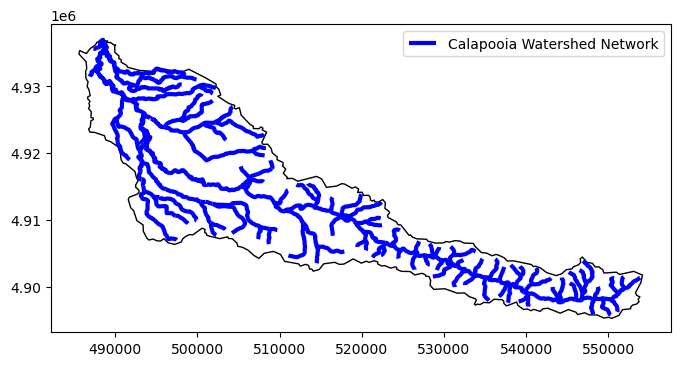

In [7]:
Calapooia = Calapooia.to_crs(3157)
basin = basin.to_crs(3157)
ax = basin.plot(facecolor="none", edgecolor="k", figsize=(8, 4))
Calapooia.plot(ax=ax, lw=3, color="blue", zorder=2, label="Calapooia Watershed Network")
ax.legend(loc="best")
ax.set_aspect("auto")

## Remember our subset of soil metrics from earlier?
- Let's look at our list of specific metric names
- Then we'll pick one and get local catchment and watershed values for that metric
- We'll use the COMIDs for our streamlines for the Calapooia Basin to define features we want

In [8]:
print(soil_metrics['METRIC_NAME'])


23        Perm
28    AgKffact
29      Kffact
89        Clay
90        Sand
91      RckDep
92       WtDep
93          Om
Name: METRIC_NAME, dtype: object


## Let's pick `Kffact` which is the erodibility factor of soils
- Pass metric name and COMIDs from Calapooia to `streamcat` function in `pynhd`

In [9]:
import pynhd
attrs = pynhd.streamcat('Kffact', 
                        comids=Calapooia['nhdplus_comid'], 
                        metric_areas=["catchment","watershed"])

In [45]:
attrs.head()

,COMID,WSAREASQKM,CATAREASQKM,KFFACTCAT,KFFACTWS
0,23763529,823.9293,0.1539,0.2800,0.2858
1,23763531,821.5407,2.1456,0.3051,0.2857
2,23763533,781.5537,6.7284,0.3171,0.2837
3,23763535,769.7061,26.8497,0.3223,0.2830
4,23763537,719.3394,4.2057,0.3273,0.2796


## Merge our StreamCat data with spatial flowlines for the Calapooia
- `pandas` is picky and we have to make sure the data types of our join column, COMID, is the same

In [10]:
import pandas as pd
Calapooia['nhdplus_comid'] = Calapooia['nhdplus_comid'].astype('Int64')
Calapooia = pd.merge(Calapooia, attrs, how="left",
                     left_on='nhdplus_comid', right_on='COMID')

## Map our soil erodibility metric
- We'll map the catchment value for each reach and then the watershed value

In [ ]:
Calapooia.plot(
    figsize=(8, 4),
    column="KFFACTCAT",
    cmap="plasma",
    legend=True,
    legend_kwds={"label": "Mean Catchment Soil Erodibility Factor"},
)

<Axes: >

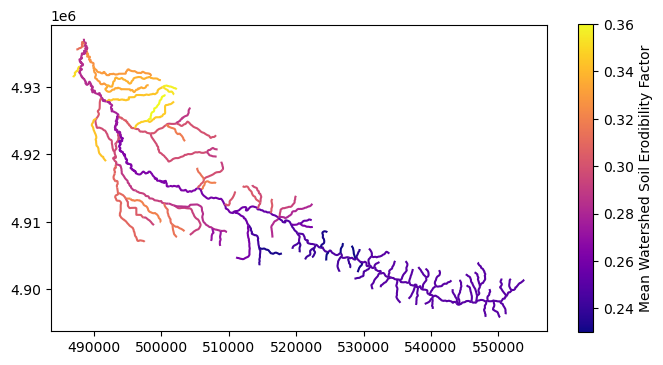

In [73]:
Calapooia.plot(
    figsize=(8, 4),
    column="KFFACTWS",
    cmap="plasma",
    legend=True,
    legend_kwds={"label": "Mean Watershed Soil Erodibility Factor"},
)

## The Magic is Ease of Integrating with Other Web Services
Here we'll:
- pull in the same NWIS stations as we did in R using the `nldi` in `pynhd`
- Plot the stations along with streamlines and basin outline
- Use `pygeohydro` from `HyRiver` stack to access NWIS stations
- Use `xarray` and `plot` to view station info and hydrograph for a station

### We use `nldi` function to again navigate upstream from a given COMID and gather NWIS stations

In [14]:
stations = nldi.navigate_byid(
    fsource="comid",
    fid=comid,
    navigation="upstreamTributaries",
    source="nwissite",
)

### Plot the NWIS stations we just gathered along with watershed boundary and flowlines

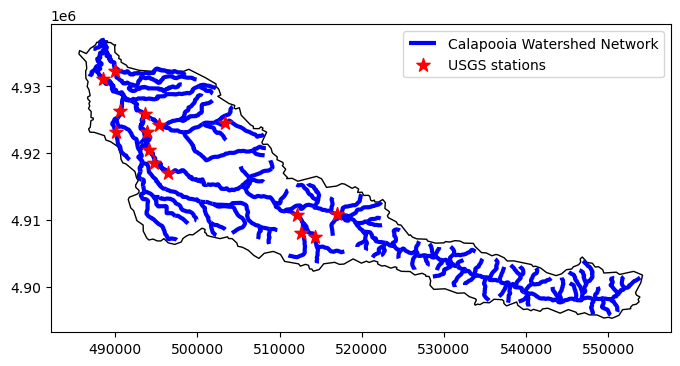

In [18]:
stations = stations.to_crs(3157)

ax = basin.plot(facecolor="none", edgecolor="k", figsize=(8, 4))
Calapooia.plot(ax=ax, lw=3, color="blue", zorder=2, 
               label="Calapooia Watershed Network")
stations.plot(ax=ax, label="USGS stations", marker="*", markersize=100, 
              zorder=4, color="r")
ax.legend(loc="best")
ax.set_aspect("auto")

### Get NWIS station information as an xarray dataset

In [15]:
import pandas as pd
import xarray as xr
import pygeohydro as gh
from pygeohydro import NWIS, plot

dates = ("1935-10-01", "1990-09-30")
stations = '14172000'
nwis = NWIS()
qobs = nwis.get_streamflow(stations, dates, mmd=True)
qobs_ds = nwis.get_streamflow(stations, dates, mmd=True, to_xarray=True)
qobs_ds

<xarray.Dataset>
Dimensions:       (time: 20089, station_id: 1)
Coordinates:
  * time          (time) datetime64[ns] 1935-10-01T08:00:00 ... 1990-09-30T07...
  * station_id    (station_id) object 'USGS-14172000'
Data variables:
    discharge     (time, station_id) float64 0.1529 0.1529 ... 0.2069 0.1979
    alt_acy_va    (station_id) float64 0.1
    alt_datum_cd  (station_id) <U6 'NGVD29'
    alt_va        (station_id) float64 527.6
    begin_date    (station_id) <U10 '1935-10-01'
    dec_lat_va    (station_id) float64 44.35
    dec_long_va   (station_id) float64 -122.8
    end_date      (station_id) <U10 '1990-09-30'
    huc_cd        (station_id) <U8 '17090003'
    station_nm    (station_id) <U27 'Calapooia R At Holley, Oreg'
Attributes:
    tz:       UTC

### Plot hydro signatures for station using hydrosignature functions in `pygeohydro`

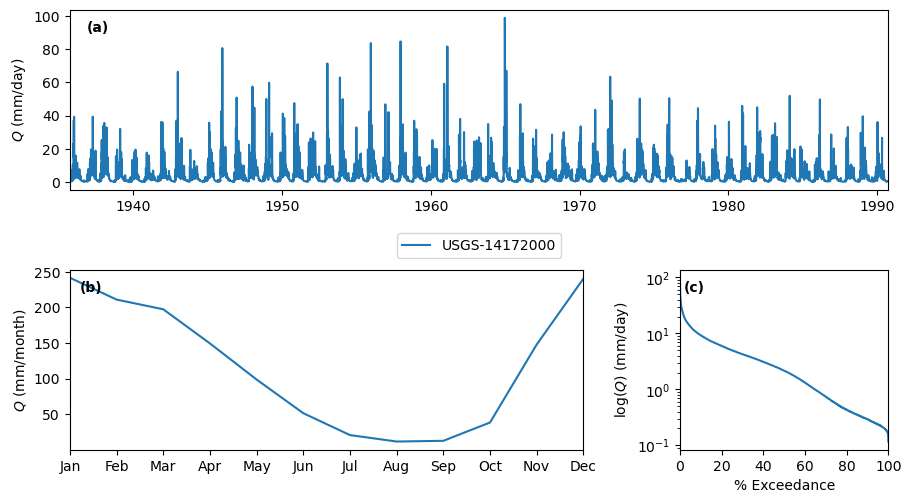

In [5]:
plot.signatures(qobs, output="_static/example_plots_signatures.png")

# Questions?



# Thank You!



### weber.marc@epa.gov